# Import modules needed

In [1]:
import numpy as np
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm import tqdm

# Functions

These functions below deal with the Elmegreen fractal generating algorithm itself.

The funtion `coord_func` is equivalent to the equation:

$$
x_n = x_{n-1} + \frac{|2\mathcal{L} - 1 |}{\mathcal{S}^g}
$$

where $\mathcal L$ is a linear random deviate on the interval $[0,1]$, $\mathcal S$ is the scaling parameter as described by Elmegreen (1997), and $g$ is the generation. This function generates $\mathcal F$ values of $x_n$, described as the number of children.

The function `fractal_point_gen` defines the logic needed to generate the points which constitute the fractal field. The `integer` parameter let's the function decide whether we want an integer $\mathcal S$ (`integer='S'`) or an integer $\mathcal F$ (`integer ='F'`). Subsequently, the function has the optional parameters `S` and `F`, one of which must be defined depending on the choice of `integer`. The function also takes as parameters; the number of generations $\mathcal G$, the fractal dimension, $D$, and the Euclidean dimension, $E$.

If we want an integer $\mathcal S$ the function calculates, $\mathcal{F}$, $\mathcal{F}_{\rm ST}$, $\mathcal{F}_{\rm LO}$, $\mathcal{F}_{\rm HI}$, and $\Delta\mathcal{F}$. It then sets up the appropriate values of $\mathcal{F}$ and $\mathcal G$ with which to pass to `coord_func`. The first $\mathcal F$ value is equal to $\mathcal{F}_{\rm ST}$, the rest are set as follows:

\begin{eqnarray}
{\cal F}_{_{\rm LO}}\,,&{\rm if}&{\cal L}>\Delta{\cal F}\,,\\
{\cal F}_{_{\rm HI}}\,,&{\rm if}&{\cal L}<\Delta{\cal F}\,.
\end{eqnarray}

A set of points are generated $E$ times to get an $E$-dimensional set of coordinates.

`fractal_point_gen` also has the option to pass these coordinates to the `star_culling` function before returning them.

The function `star_culling` takes a set of coordinates and culls points randomly to a desired number.

The function `fractal_field_gen` returns a histogram based on `fractal_point_gen`.

In [2]:
def coord_func(x,S,g,F):
    L = np.random.random(F)
    return x + 2*(L-0.5)/S**g

def fractal_point_gen(integer,G,D,E=2,S=None,F=None,N_points=None):
    if integer == 'S':
        F=S**D
        F_st = int(F+0.5)
        F_lo = int(F)
        F_hi = F_lo+1
        F_change = F - F_lo
        L = np.random.random(G-1)
        F_array = np.concatenate((np.array([F_st]),np.where(L>F_change,F_lo,F_hi)),axis=None)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g,f in np.array([G_array,F_array]).T:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,f)]
            points.append(x)
    if integer == 'F':
        print('Not Implemented')
    if N_points:
        points = star_culling(points,N_points)
    return points

def star_culling(points, N_points):
    while len(points[0])>N_points:
            n=1+int(np.random.random()*(len(points[0])-1))
            del points[0][n-1]
            del points[1][n-1]
    return points

def fractal_field_gen(integer,G,D,E,S=None,F=None,N_pix=None,seed=None):
    if seed != None:
        np.random.seed(int(seed))  
    if N_pix==None:
        N_pix = S**G
    fractal_points = fractal_point_gen(integer,G,D,E,S,F)
    fractal_field = np.histogramdd(fractal_points, bins=int(N_pix))[0]
    return fractal_field

In [3]:
def ordered_separations(points):
    coords = [(point[0], point[1]) for point in np.array(points).T]
    distance_matrix = distance.cdist(coords, coords, 'euclidean')
    separations = np.unique(distance_matrix[distance_matrix != 0])
    return separations

def two_pt_corr(coords,separations,s):
    N_s = np.sum(np.where(separations<s,1,0))
    I=len(coords)
    P_s = 2*N_s/(I*(I-1))
    return P_s

# Integer S

In [4]:
S_LIST=[2,3]
D = 2.3
G_LIST = [6,4]
E=2

params = np.array([S_LIST,G_LIST]).T
params

array([[2, 6],
       [3, 4]])

In [5]:
star_fields = [fractal_point_gen('S',g,D,E,s) for s,g in params]
sizes_fields= np.array([len(field[0]) for field in star_fields])
min_stars = np.min(sizes_fields)
culled_star_fields = [star_culling(field, min_stars) for field in star_fields]
len(culled_star_fields[0][0]),len(culled_star_fields[1][0])

(12500, 12500)

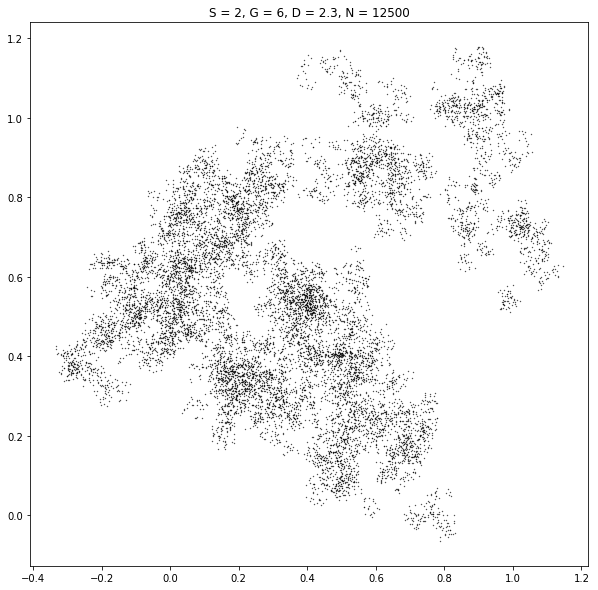

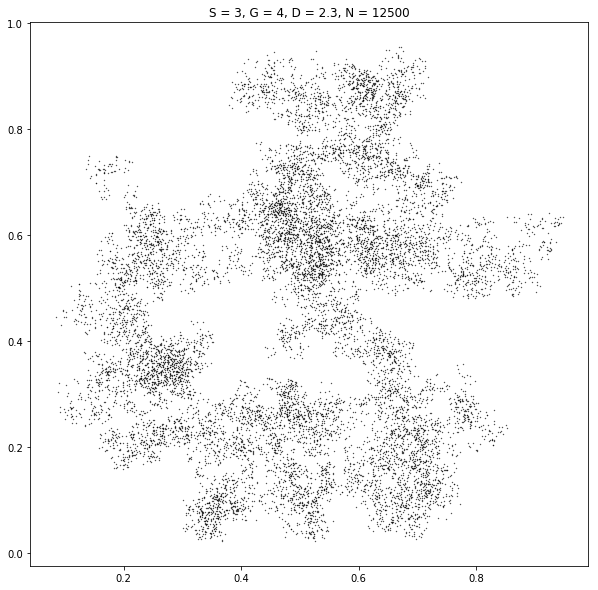

In [6]:
for i,field in enumerate(culled_star_fields):    
    plt.figure(figsize=(10,10))
    #plt.hist2d(*field, bins=128)
    plt.title('S = {}, G = {}, D = {}, N = {}'.format(S_LIST[i],G_LIST[i],D,len(field[i])))
    plt.scatter(*field, s=.1, c='k')
    plt.show()

In [7]:
separations_list = [ordered_separations(field) for field in tqdm(culled_star_fields)]
separations_list

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:51<00:00, 25.78s/it]


[array([3.39871807e-05, 6.81449499e-05, 1.02497842e-04, ...,
        1.49943700e+00, 1.50000472e+00, 1.50184346e+00]),
 array([1.49055298e-05, 3.28189179e-05, 4.96090458e-05, ...,
        9.87512457e-01, 9.87730393e-01, 9.89501562e-01])]

In [8]:
s_factors = np.linspace(0,2,1000)
P_s_list = [[two_pt_corr(culled_star_fields[i],seps,s) for s in tqdm(s_factors)] for i,seps in enumerate(separations_list)]
len(P_s_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:35<00:00,  1.99it/s]


2

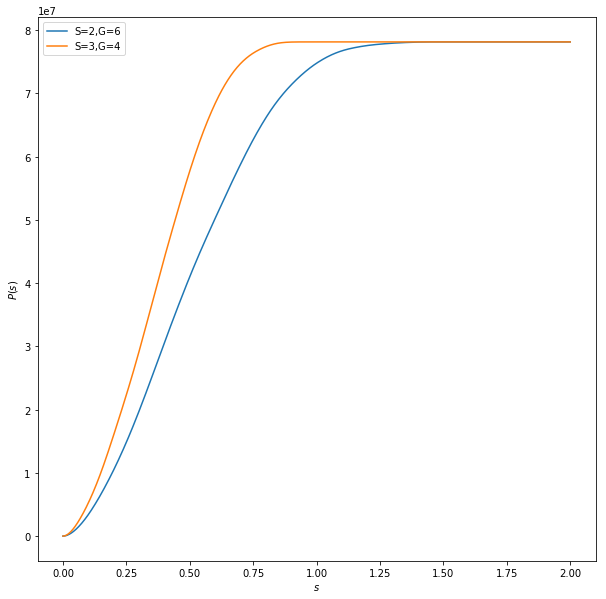

In [9]:
plt.figure(figsize=(10,10))
for i,P_s in enumerate(P_s_list):
    plt.plot(s_factors,P_s, label='S={},G={}'.format(params[i][0],params[i][1]))
plt.legend()
plt.ylabel(r'$P(s)$')
plt.xlabel(r'$s$')
plt.show()